In [1]:
from collections import defaultdict
from trajdata import AgentType, UnifiedDataset
from trajdata.maps import MapAPI


env_name: str = "nusc_mini"

dataset = UnifiedDataset(
    desired_data=[env_name],
    data_dirs={  # Remember to change this to match your filesystem!
        env_name: "data/nuScenes/v1.0-mini_root",
    },
    cache_location="~/.unified_data_cache",
    only_types=[AgentType.VEHICLE],
    agent_interaction_distances=defaultdict(lambda: 50.0),
    incl_raster_map=True,
    raster_map_params={
        "px_per_m": 2,
        "map_size_px": 400,
        "offset_frac_xy": (-0.5, 0.0),
        "return_rgb": False,
    },
    desired_dt=0.1,
    num_workers=4,
    verbose=True,
)

map_api = MapAPI(dataset.cache_path)

Loading data for matched scene tags: ['nusc_mini-boston-mini_train', 'singapore-nusc_mini-mini_train', 'boston-nusc_mini-mini_val', 'singapore-nusc_mini-mini_val']


Calculating Agent Data (Serially): 100%|██████████| 10/10 [00:00<00:00, 23160.15it/s]

10 scenes in the scene index.



Structuring Agent Data Index: 100%|██████████| 10/10 [00:00<00:00, 7711.54it/s]


In [2]:
from trajdata import AgentBatch
from trajdata.maps import VectorMap
from trajdata.simulation import SimulationScene
from trajdata.data_structures.scene_metadata import Scene


SCENE_IDX = 0

desired_scene: Scene = list(dataset.scenes())[SCENE_IDX]
sim_scene: SimulationScene = SimulationScene(
    env_name=env_name,
    scene_name=f"sim_scene-{SCENE_IDX:04d}",
    scene=desired_scene,
    dataset=dataset,
    init_timestep=0,
    freeze_agents=True,
)

## get vector map
vector_map: VectorMap = map_api.get_map(
    f"{env_name}:{desired_scene.location}"
)

## generate paths of agents

In [3]:
import torch
import numpy as np
from typing import Dict, List, Tuple, Union


## generate paths of agents
PATH_LENGTH = 500

obs: AgentBatch = sim_scene.reset()

num_agents = len(obs.agent_name)
curr_pos_agents = obs.curr_agent_state.position
curr_yaw_agents = obs.curr_agent_state.heading

curr_xyzh_agents = np.zeros((num_agents, 4))
curr_xyzh_agents[:, :2] = curr_pos_agents
curr_xyzh_agents[:, -1:] = curr_yaw_agents

path_agents: List[torch.tensor] = list()
for idx, agent_name in enumerate(obs.agent_name):
    curr_xyzh = curr_xyzh_agents[idx]
    path = curr_xyzh[None]
    lanes = vector_map.get_current_lane(curr_xyzh)

    if len(lanes) > 0:
        # get rank-1 lane as current lane
        curr_lane = lanes[0]
        path = curr_lane.center.xyzh
        total_path_length = np.linalg.norm(curr_lane.center.xy[1:] - curr_lane.center.xy[:-1], axis=1).sum()
        # random select next lanes until reach PATH_LENGTH
        while total_path_length < PATH_LENGTH:
            next_lanes = list(curr_lane.next_lanes)
            if len(next_lanes) == 0:
                break
            next_lane = vector_map.get_road_lane(next_lanes[np.random.randint(len(next_lanes))])
            path = np.vstack([path, next_lane.center.xyzh])
            total_path_length += np.linalg.norm(next_lane.center.xy[1:] - next_lane.center.xy[:-1], axis=1).sum()
            curr_lane = next_lane
    
    path_agents.append(torch.from_numpy(
        np.hstack([path[:, :2], path[:, -1:]])
    ))

### visualize current state of agents

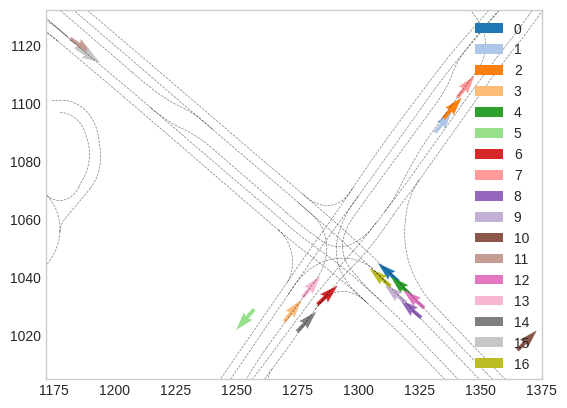

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# visualize current state of agents
plt.figure()

x_min, x_max = curr_xyzh_agents[:, 0].min(), curr_xyzh_agents[:, 0].max()
y_min, y_max = curr_xyzh_agents[:, 1].min(), curr_xyzh_agents[:, 1].max()
plt.axis([x_min-10, x_max+10, y_min-10, y_max+10])
plt.grid(False)

for lane in vector_map.lanes:
    if lane.center.midpoint[0] > x_min-100 and \
       lane.center.midpoint[0] < x_max+100 and \
       lane.center.midpoint[1] > y_min-100 and \
       lane.center.midpoint[1] < y_max+100:
        plt.plot(
            lane.center.points[:, 0], lane.center.points[:, 1],
            'k--', linewidth=0.5, alpha=0.5
        )
    
color_map = plt.get_cmap('tab20').colors
color_map = [color_map[i % len(color_map)] for i in range(num_agents)]

for agent_idx in range(num_agents):
    agent_x = curr_xyzh_agents[agent_idx, 0]
    agent_y = curr_xyzh_agents[agent_idx, 1]
    agent_yaw = curr_xyzh_agents[agent_idx, -1]
    
    plt.quiver(
        agent_x, agent_y, np.cos(agent_yaw), np.sin(agent_yaw),
        color=color_map[agent_idx], label=agent_idx
    )
    
plt.legend()
plt.show()
plt.close()

### visualize paths of agents

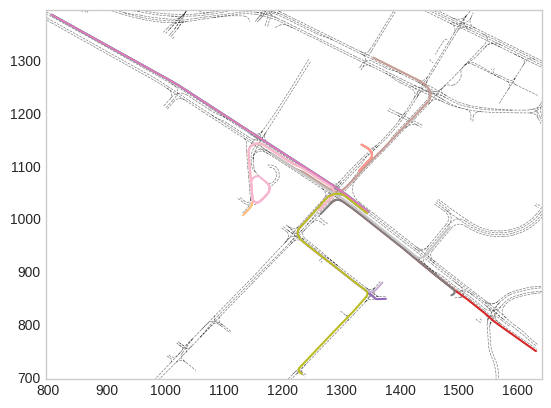

In [19]:
import numpy as np
from matplotlib import pyplot as plt

# visualize paths of agents
plt.figure()

color_map = plt.get_cmap('tab20').colors
color_map = [color_map[i % len(color_map)] for i in range(num_agents)]

x_min = y_min = np.inf
x_max = y_max = -np.inf

for agent_idx, path in enumerate(path_agents):
    x_min = min(path[:, 0].min(), x_min)
    y_min = min(path[:, 1].min(), y_min)
    x_max = max(path[:, 0].max(), x_max)
    y_max = max(path[:, 1].max(), y_max)
    
    plt.plot(
        path[:, 0], path[:, 1],
        color=color_map[agent_idx],
        label=agent_idx,
        zorder=1,
    )
    
plt.axis([x_min-10, x_max+10, y_min-10, y_max+10])
plt.grid(False)

for lane in vector_map.lanes:
    if lane.center.midpoint[0] > x_min-100 and \
       lane.center.midpoint[0] < x_max+100 and \
       lane.center.midpoint[1] > y_min-100 and \
       lane.center.midpoint[1] < y_max+100:
        plt.plot(
            lane.center.points[:, 0], lane.center.points[:, 1],
            'k--', linewidth=0.5, alpha=0.5, zorder=0,
        )

plt.show()
plt.close()

## simulation

In [5]:
import time
import math
import torch
from copy import deepcopy


def constant_tracking(state, path, dt):
    '''
    Args:
        state: current state of the vehicle, of size [x, y, yaw, speed]
        path: the path to follow, of size (N, [x, y, yaw])
        dt: time duration
    '''
    
    # find the nearest point in the path
    dists = torch.norm(path[:, :2] - state[None, :2], dim=1)
    nearest_index = torch.argmin(dists)
    
    # find the target point
    lookahead_distance = state[3] * dt
    target = path[-1]
    is_end = True
    for i in range(nearest_index+1, len(path)):
        if torch.norm(path[i, :2] - state[:2]) > lookahead_distance:
            target = path[i]
            is_end = False
            break
    
    # compute the new state
    target_distance = torch.norm(target[:2] - state[:2])
    ratio = lookahead_distance / target_distance.clamp(min=1e-6)
    ratio = ratio.clamp(max=1.0)
    
    new_state = deepcopy(state)
    new_state[:2] = state[:2] + ratio * (target[:2] - state[:2])
    new_state[2] = torch.atan2(
        state[2].sin() + ratio * (target[2].sin() - state[2].sin()),
        state[2].cos() + ratio * (target[2].cos() - state[2].cos())
    )
    if is_end:
        new_state[3] = 0
    
    return new_state


def constant_headaway(states, num_steps, dt):
    '''
    Args:
        states: current states of a batch of vehicles, of size (num_agents, [x, y, yaw, speed])
        num_steps: number of steps to move forward
        dt: time duration
    Return:
        trajs: the trajectories of the vehicles, of size (num_agents, num_steps, [x, y, yaw, speed])
    '''
    
    # state: [x, y, yaw, speed]
    x = states[:, 0]
    y = states[:, 1]
    yaw = states[:, 2]
    speed = states[:, 3]

    # Generate time steps
    t_steps = torch.arange(num_steps, device=states.device) * dt
    
    # Calculate dx and dy for each step
    dx = torch.outer(speed * torch.cos(yaw), t_steps)
    dy = torch.outer(speed * torch.sin(yaw), t_steps)

    # Update x and y positions
    x_traj = x.unsqueeze(1) + dx
    y_traj = y.unsqueeze(1) + dy

    # Replicate the yaw and speed for each time step
    yaw_traj = yaw.unsqueeze(1).repeat(1, num_steps)
    speed_traj = speed.unsqueeze(1).repeat(1, num_steps)
    
    # Stack the x, y, yaw, and speed components to form the trajectory
    trajs = torch.stack((x_traj, y_traj, yaw_traj, speed_traj), dim=-1)

    return trajs    
    

class IDM:
    def __init__(
        self, v0=30.0, s0=10.0, T=2.0, a=2.0, b=4.0, delta=4.0,
        lookahead_path_length=100, lead_distance_threshold=1.0
    ):
        '''
        Args:
            v0: desired speed
            s0: minimum gap
            T: safe time headway
            a: max acceleration
            b: comfortable deceleration
            delta: acceleration exponent
            lookahead_path_length: the length of path to look ahead
            lead_distance_threshold: the distance to consider a vehicle as a lead vehicle
        '''        
        self.v0 = v0
        self.s0 = s0
        self.T = T
        self.a = a
        self.b = b
        self.delta = delta
        self.lookahead_path_length = lookahead_path_length
        self.lead_distance_threshold = lead_distance_threshold
        
    
    def update(self, state, path, dt, neighbors):
        '''
        Args:
            state: current state of the vehicle, of size [x, y, yaw, speed]
            path: the path to follow, of size (N, [x, y, yaw])
            dt: time duration
            neighbors: the future states of the neighbors, of size (K, T, [x, y, yaw, speed])
        '''
        
        # find the nearest point in the path
        dists = torch.norm(path[:, :2] - state[None, :2], dim=1)
        nearest_index = torch.argmin(dists)
        
        # find the target point
        lookahead_distance = state[3] * dt
        target = path[-1]
        is_end = True
        for i in range(nearest_index+1, len(path)):
            if torch.norm(path[i, :2] - state[:2]) > lookahead_distance:
                target = path[i]
                is_end = False
                break
        
        # distance between neighbors and the path
        lookahead_path = path[nearest_index+1:][:self.lookahead_path_length]
        lookahead_neighbors = neighbors[..., None, :].expand(
            -1, -1, lookahead_path.shape[0], -1
        ) # (K, T, n, 4)
        
        dists_neighbors = torch.norm(
            lookahead_neighbors[..., :2] - lookahead_path[None, None, :, :2], dim=-1
        ) # (K, T, n)
        indices_neighbors = torch.arange(
            lookahead_path.shape[0]
        )[None, None].expand_as(dists_neighbors).to(state.device)
        
        # determine lead vehicles
        is_lead = (dists_neighbors < self.lead_distance_threshold)
        if is_lead.any():            
            # compute lead distance
            indices_lead = indices_neighbors[is_lead] # (num_lead)
            lookahead_lengths = torch.cumsum(torch.norm(
                lookahead_path[1:, :2] - lookahead_path[:-1, :2], dim=1
            ), dim=0)
            lookahead_lengths = torch.cat([lookahead_lengths, lookahead_lengths[-1:]])
            lead_distance = lookahead_lengths[indices_lead]
            
            # compute lead speed
            states_lead = lookahead_neighbors[is_lead] # (num_lead, 4)
            ori_speed_lead = states_lead[:, 3]
            yaw_lead = states_lead[:, 2]
            yaw_path = lookahead_path[indices_lead, 2]
            lead_speed = ori_speed_lead * (yaw_lead - yaw_path).cos()
        
            # compute acceleration
            ego_speed = state[3]
            delta_v = ego_speed - lead_speed
            s_star = self.s0 + \
                (ego_speed * self.T + ego_speed * delta_v / (2 * math.sqrt(self.a * self.b))).clamp(min=0)
            acceleration = self.a * (1 - (ego_speed / self.v0) ** self.delta - (s_star / lead_distance) ** 2)
            acceleration = acceleration.min()
        else:
            acceleration = self.a
        
        # compute the new state
        target_distance = torch.norm(target[:2] - state[:2])
        ratio = lookahead_distance / target_distance.clamp(min=1e-6)
        ratio = ratio.clamp(max=1.0)
        
        new_state = deepcopy(state)
        new_state[:2] = state[:2] + ratio * (target[:2] - state[:2])
        new_state[2] = torch.atan2(
            state[2].sin() + ratio * (target[2].sin() - state[2].sin()),
            state[2].cos() + ratio * (target[2].cos() - state[2].cos())
        )
        if is_end:
            new_state[3] = 0
        else:
            new_state[3] = (state[3] + acceleration * dt).clamp(min=0)
        
        return new_state
    


### Attack Planner

In [6]:
import math
import random
import numpy as np
from matplotlib import pyplot as plt
from trajdata.maps import VectorMap
from Pplan.Sampling.spline_planner import SplinePlanner


class AttackPlanner:
    def __init__(self, tf, dt, device='cpu'):
        self.tf = tf
        self.dt = dt
        self.device = device
        self.predict_steps = math.ceil(tf/dt)
        
        self.planner = SplinePlanner(
            device,
            N_seg=self.predict_steps,
            acce_grid=torch.linspace(-2, 5, 10).to(self.device),
            acce_bound=[-6, 5],
            vbound=[-2, 50]
        )
        # TODO allow all yaw
        self.planner.psi_bound = [-math.pi*2, math.pi*2]
        
        self.exec_traj = None
        self.exec_pointer = 1
    
    
    def update(
        self, state, vector_map: VectorMap,
        neighbors, attacked_states,
        new_plan=True
    ):
        '''
        Args:
            state: current state of the vehicle, of size [x, y, yaw, speed]
            vector_map: the vector map
            attacked_states: future states of the attacked agent, of size (T, [x, y, yaw, speed])
            neighbors: future states of the neighbors, of size (K, T, [x, y, yaw, speed])
            new_plan: whether to generate a new plan
        '''
        assert self.exec_pointer > 0
        
        # directly execute the current plan
        if not new_plan:
            if self.exec_traj is not None and \
               self.exec_pointer < self.exec_traj.shape[0]:
                next_state = self.exec_traj[self.exec_pointer]
                self.exec_pointer += 1
                return next_state
            else:
                new_plan = True
        
        assert attacked_states.shape[0] == self.predict_steps
        
        # state: [x, y, yaw, speed]
        x, y, yaw, speed = state
        
        # query vector map to get lanes
        query_xyz = np.array([x, y, 0])
        lanes = vector_map.get_lanes_within(query_xyz, dist=30)
        lanes = [l.center.xyzh[:, [0,1,3]] for l in lanes]
        
        # for lane in lanes:
        #     plt.plot(lane[:, 0], lane[:, 1], 'k--', linewidth=0.5, alpha=0.5)
        
        # generate spline trajectories
        x0 = torch.tensor([x, y, speed, yaw], device=self.device)
        trajs, xf_set = self.planner.gen_trajectories(x0, self.tf, lanes, dyn_filter=True) # (num_trajs, T-1, [x, y, v, a, yaw, r, t])
        if trajs.shape[0] == 0:
            trajs = constant_headaway(state[None], self.predict_steps, self.dt) # (1, T, [x, y, yaw, speed])
        else:
            trajs = torch.cat([
                state[None, None].expand(trajs.shape[0], -1, -1),
                trajs[..., [0, 1, 4, 2]]
            ], dim=1) # (num_trajs, T, [x, y, yaw, speed]
        
        # for traj in trajs:
        #     plt.plot(traj[:, 0], traj[:, 1])
        # plt.show()
        
        # select the best trajectory
        # traj_best = trajs[random.randint(0, trajs.shape[0]-1)]
        attack_distance = torch.norm(attacked_states[None, :, :2] - trajs[..., :2], dim=-1)
        cost_attack = attack_distance.min(dim=1).values
        
        cost_collision = (torch.norm(
            neighbors[None, ..., :2] - trajs[:, None, :, :2], dim=-1
        ).min(dim=-1).values < 2.0).sum(dim=-1)
        
        cost = cost_attack + cost_collision
        traj_best = trajs[cost.argmin()]
        
        # produce next state
        self.exec_traj = traj_best
        self.exec_pointer = 1
        next_state = self.exec_traj[self.exec_pointer]
        self.exec_pointer += 1
        
        return next_state
        

In [7]:
import torch
from tqdm import trange
from copy import deepcopy
from functools import partial


PREDICT_STEPS = 20
NUM_NEIGHBORS = 3
ATTACK_IDX = 13
TESTED_IDX = 0
PLANNER_FREQ = 5


## set up controllers for agents
controller_agents: Dict[str, Union[IDM, AttackPlanner]] = dict()
for idx, agent_name in enumerate(obs.agent_name):
    if idx == ATTACK_IDX:
        tf = PREDICT_STEPS * desired_scene.dt
        controller_agents[agent_name] = AttackPlanner(tf=tf, dt=desired_scene.dt)
        continue
    agent_length = obs.agent_hist_extent[idx, -1, 0]
    controller_agents[agent_name] = IDM(s0=agent_length*2)


## run simulation
obs: AgentBatch = sim_scene.reset()

curr_x_agents = obs.curr_agent_state.position[..., 0]
curr_y_agents = obs.curr_agent_state.position[..., 1]
curr_yaw_agents = obs.curr_agent_state.heading.squeeze(-1)
curr_speed_agents = obs.curr_agent_state.velocity.norm(dim=-1)

sim_x = [deepcopy(curr_x_agents)]
sim_y = [deepcopy(curr_y_agents)]
sim_yaw = [deepcopy(curr_yaw_agents)]

for t in trange(1, sim_scene.scene.length_timesteps):
    # predict the future of agents
    future_states = constant_headaway(
        torch.stack([curr_x_agents, curr_y_agents, curr_yaw_agents, curr_speed_agents], dim=-1),
        num_steps=PREDICT_STEPS, dt=desired_scene.dt
    )
    
    for idx, agent_name in enumerate(obs.agent_name):
        curr_x = curr_x_agents[idx].item()
        curr_y = curr_y_agents[idx].item()
        curr_yaw = curr_yaw_agents[idx].item()
        curr_speed = curr_speed_agents[idx].item()
        
        state = torch.tensor([curr_x, curr_y, curr_yaw, curr_speed])
        
        # find closet neighbors
        curr_xy_agents = torch.stack([curr_x_agents, curr_y_agents], dim=-1)
        distance_agents = torch.norm(
            curr_xy_agents - state[:2], dim=-1
        )
        neighbor_idx = torch.argsort(distance_agents)[1:NUM_NEIGHBORS+1]
        if idx == ATTACK_IDX:
            neighbor_idx = neighbor_idx[neighbor_idx != TESTED_IDX]
        neighbors = future_states[neighbor_idx]
        
        # next_state = constant_tracking(
        #     state, path_agents[idx], dt=desired_scene.dt
        # )
        if idx == ATTACK_IDX:
            next_state = controller_agents[agent_name].update(
                state, vector_map, neighbors=neighbors,
                attacked_states=future_states[TESTED_IDX],
                new_plan=(t % PLANNER_FREQ == 0)
            )
        else:
            next_state = controller_agents[agent_name].update(
                state, path_agents[idx], dt=desired_scene.dt, neighbors=neighbors
            )
        
        curr_x_agents[idx] = next_state[0]
        curr_y_agents[idx] = next_state[1]
        curr_yaw_agents[idx] = next_state[2]
        curr_speed_agents[idx] = next_state[3]
    
    sim_x.append(deepcopy(curr_x_agents))
    sim_y.append(deepcopy(curr_y_agents))
    sim_yaw.append(deepcopy(curr_yaw_agents))

sim_x = torch.stack(sim_x, dim=1)
sim_y = torch.stack(sim_y, dim=1)
sim_yaw = torch.stack(sim_yaw, dim=1)

/home/linlongzhong/Projects/Pplan/Pplan/Sampling/spline_planner.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.acce_grid = torch.tensor(acce_grid).to(self.device)
/home/linlongzhong/Projects/Pplan/Pplan/Sampling/forward_sampler.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.accels = torch.tensor(acce_grid,device=self.device)
/home/linlongzhong/Projects/Pplan/Pplan/Sampling/forward_sampler.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dhm_grid = torch.tensor(dhm_grid,device=self.device)
100%|██████████| 2

### KING Generation

In [5]:
from tqdm import trange
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt


def drivable_to_sdf(drivable: torch.Tensor) -> torch.Tensor:
    device = drivable.device
    mask = drivable.bool().cpu().numpy()
    dist_inside = distance_transform_edt(mask)
    dist_outside = distance_transform_edt(~mask)
    sdf = dist_outside - dist_inside
    return torch.from_numpy(sdf).float().to(device)


class Bicycle(torch.nn.Module):
    def __init__(
        self,
        WHEEL_BASE: float = 2.7, # [m]
        MAX_STEER: float = 0.6, # [rad]
        MAX_SPEED: float = 30.0, # [m/s]
        MAX_ACCEL: float = 8.0, # [m/s^2]
        MAX_STEER_RATE: float = 0.6, # [rad/s]
    ):
        super().__init__()
        self.WHEEL_BASE = WHEEL_BASE
        self.MAX_STEER = MAX_STEER
        self.MAX_SPEED = MAX_SPEED
        self.MAX_ACCEL = MAX_ACCEL
        self.MAX_STEER_RATE = MAX_STEER_RATE

    def forward(self, init_state: torch.Tensor, controls: torch.Tensor, dt: float) -> torch.Tensor:
        states = [init_state]
        s = init_state
        for t in range(controls.shape[-2]):
            s = self.step(s, controls[..., t, :], dt)
            states.append(s)
        return torch.stack(states, dim=-2)

    def step(self, state: torch.Tensor, control: torch.Tensor, dt: float) -> torch.Tensor:
        x, y, yaw, v, delta = state.unbind(-1)
        a, d_dot = control.unbind(-1)

        delta_next = torch.clamp(delta + d_dot * dt, -self.MAX_STEER, self.MAX_STEER)
        v_next = torch.clamp(v + a * dt, 0.0, self.MAX_SPEED)

        beta = torch.atan(0.5 * torch.tan(delta_next))
        yaw_next = yaw + v_next * torch.sin(beta) / (self.WHEEL_BASE / 2) * dt

        x_next = x + v_next * torch.cos(yaw_next) * dt
        y_next = y + v_next * torch.sin(yaw_next) * dt

        return torch.stack((x_next, y_next, yaw_next, v_next, delta_next), dim=-1)


class KING:
    def __init__(
        self,
        kinematics: Bicycle,
        num_iters: int = 10,
        tested_coll_weight: float = 1.0,
        others_coll_weight: float = 5.0,
        offroad_weight: float = 10.0,
        dynamic_weight: float = 0.1,
        lr: float = 5e-2,
        device = 'cpu',
    ) -> None:
        self.kinematics = kinematics
        self.num_iters = num_iters
        self.tested_coll_weight = tested_coll_weight
        self.others_coll_weight = others_coll_weight
        self.offroad_weight = offroad_weight
        self.dynamic_weight = dynamic_weight
        self.lr = lr
        self.device = device

    def run(
        self,
        sim_scene: SimulationScene,
        path_agents: torch.Tensor,
        attack_idx: int,
        tested_idx: int,
    ) -> torch.Tensor:
        horizon = sim_scene.scene.length_timesteps - 1
        dt = sim_scene.scene.dt
        
        obs: AgentBatch = sim_scene.reset()
        curr_x_agents = obs.curr_agent_state.position[..., 0].to(self.device)
        curr_y_agents = obs.curr_agent_state.position[..., 1].to(self.device)
        curr_yaw_agents = obs.curr_agent_state.heading.squeeze(-1).to(self.device)
        curr_speed_agents = obs.curr_agent_state.velocity.norm(dim=-1).to(self.device)

        path_agents = [path.to(self.device) for path in path_agents]
        
        controller_agents: Dict[str, IDM] = dict()
        for idx, agent_name in enumerate(obs.agent_name):
            agent_length = obs.agent_hist_extent[idx, -1, 0]
            controller_agents[agent_name] = IDM(s0=agent_length*2)

        # sdf around attack agent
        drivable = obs.maps[attack_idx][0].to(self.device)
        raster_from_world = obs.rasters_from_world_tf[attack_idx].to(self.device)
        sdf = drivable_to_sdf(drivable)

        # attack agent initialization
        if isinstance(self.kinematics, Bicycle):
            attack_s0 = torch.tensor([
                curr_x_agents[attack_idx], curr_y_agents[attack_idx], curr_yaw_agents[attack_idx],
                curr_speed_agents[attack_idx], 0.0
            ], device=self.device, dtype=torch.float32)

            attack_u = torch.nn.Parameter(
                torch.zeros(horizon, 2, device=self.device, dtype=torch.float32)
            )
        else:
            raise NotImplementedError

        optimiser = torch.optim.Adam([attack_u], lr=self.lr)

        # optimisation loop
        for iter in trange(self.num_iters):
            optimiser.zero_grad()

            attack_traj = self.kinematics(attack_s0, attack_u, dt)

            with torch.no_grad():
                sim_agents = self.unroll_simulation(
                    attack_idx, attack_traj,
                    curr_x_agents.clone(), curr_y_agents.clone(),
                    curr_yaw_agents.clone(), curr_speed_agents.clone(),
                    path_agents, controller_agents,
                    horizon, dt,
                )
            tested_traj = sim_agents[tested_idx]
            others_traj = sim_agents[[i for i in range(len(sim_agents)) if i != attack_idx and i != tested_idx]]

            # collision with tested
            tested_coll_loss = torch.norm(attack_traj[:, :2] - tested_traj[:, :2], dim=1).mean()

            # avoid others
            if len(others_traj) > 0:
                others_dist = torch.norm(attack_traj[None, :, :2] - others_traj[:, :, :2], dim=-1)
                others_coll_loss = - others_dist.min()
            else:
                others_coll_loss = torch.tensor(0., device=self.device)

            # avoid off‑road
            attack_positions_homo = torch.cat([
                attack_traj[:, :2], torch.ones_like(attack_traj[:, :1])
            ], dim=1)
            attack_positions_raster_homo = attack_positions_homo @ raster_from_world.T
            attack_positions_raster = attack_positions_raster_homo[:, :2]
            
            attack_positions_raster[:, 0] = attack_positions_raster[:, 0] / sdf.shape[1] * 2 - 1
            attack_positions_raster[:, 1] = attack_positions_raster[:, 1] / sdf.shape[0] * 2 - 1
            signed_dist = F.grid_sample(
                sdf.unsqueeze(0).unsqueeze(0),
                attack_positions_raster.unsqueeze(0).unsqueeze(0),
            ).squeeze()
            offroad_loss = signed_dist.mean()

            # dynamic constraints
            if isinstance(self.kinematics, Bicycle):
                dynamic_loss = \
                    torch.relu(torch.abs(attack_u[:, 0]) - self.kinematics.MAX_ACCEL).pow(2).mean() + \
                        torch.relu(torch.abs(attack_u[:, 1]) - self.kinematics.MAX_STEER_RATE).pow(2).mean()
            else:
                raise NotImplementedError

            loss = self.tested_coll_weight * tested_coll_loss + \
                self.others_coll_weight * others_coll_loss + \
                    self.offroad_weight * offroad_loss + \
                        self.dynamic_weight * dynamic_loss
            loss.backward()
            optimiser.step()

        return sim_agents

    def unroll_simulation(
        self,
        attack_idx: int,
        attack_traj: torch.Tensor,
        curr_x_agents: torch.Tensor,
        curr_y_agents: torch.Tensor,
        curr_yaw_agents: torch.Tensor,
        curr_speed_agents: torch.Tensor,
        path_agents: torch.Tensor,
        controller_agents: Dict[str, IDM],
        horizon: int,
        dt: float,
        predict_steps: int = 20,
        num_neighbors: int = 3,
    ):
        sim_x = [deepcopy(curr_x_agents)]
        sim_y = [deepcopy(curr_y_agents)]
        sim_yaw = [deepcopy(curr_yaw_agents)]

        for t in range(horizon):
            # predict the future of agents
            future_states = constant_headaway(
                torch.stack([curr_x_agents, curr_y_agents, curr_yaw_agents, curr_speed_agents], dim=-1),
                num_steps=predict_steps, dt=dt
            )
            
            for idx, agent_name in enumerate(obs.agent_name):
                curr_x = curr_x_agents[idx].item()
                curr_y = curr_y_agents[idx].item()
                curr_yaw = curr_yaw_agents[idx].item()
                curr_speed = curr_speed_agents[idx].item()
                
                state = torch.tensor([curr_x, curr_y, curr_yaw, curr_speed], device=self.device)
                
                # find closet neighbors
                curr_xy_agents = torch.stack([curr_x_agents, curr_y_agents], dim=-1)
                distance_agents = torch.norm(
                    curr_xy_agents - state[:2], dim=-1
                )
                neighbor_idx = torch.argsort(distance_agents)[1:num_neighbors+1]
                neighbors = future_states[neighbor_idx]
                
                if idx == attack_idx:
                    if isinstance(self.kinematics, Bicycle):
                        next_state = attack_traj[t+1]
                else:
                    next_state = controller_agents[agent_name].update(
                        state, path_agents[idx], dt=dt, neighbors=neighbors
                    )
                
                curr_x_agents[idx] = next_state[0]
                curr_y_agents[idx] = next_state[1]
                curr_yaw_agents[idx] = next_state[2]
                curr_speed_agents[idx] = next_state[3]
            
            sim_x.append(deepcopy(curr_x_agents))
            sim_y.append(deepcopy(curr_y_agents))
            sim_yaw.append(deepcopy(curr_yaw_agents))
        
        sim_x = torch.stack(sim_x, dim=1)
        sim_y = torch.stack(sim_y, dim=1)
        sim_yaw = torch.stack(sim_yaw, dim=1)

        return torch.stack([sim_x, sim_y, sim_yaw], dim=-1)



In [6]:
scene_generator = KING(
    kinematics=Bicycle(),
    num_iters=10,
    device='cuda:3',
)

sim_agents = scene_generator.run(
    sim_scene, path_agents, attack_idx=13, tested_idx=0
)

sim_x = sim_agents[..., 0].cpu()
sim_y = sim_agents[..., 1].cpu()
sim_yaw = sim_agents[..., 2].cpu()

  0%|          | 0/10 [00:00<?, ?it/s]/home/linlongzhong/anaconda3/envs/tbsim/lib/python3.8/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


### visualize simulation (static figure)

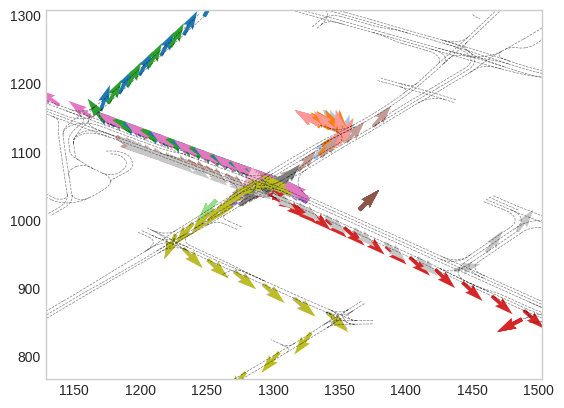

In [7]:
import numpy as np
from matplotlib import pyplot as plt

# visualize simulation of agents
interval = 10

plt.figure()

color_map = plt.get_cmap('tab20').colors
color_map = [color_map[i % len(color_map)] for i in range(num_agents)]

x_min, x_max = sim_x.min(), sim_x.max()
y_min, y_max = sim_y.min(), sim_y.max()
plt.axis([x_min-10, x_max+10, y_min-10, y_max+10])
plt.grid(False)

for lane in vector_map.lanes:
    if lane.center.midpoint[0] > x_min-100 and \
       lane.center.midpoint[0] < x_max+100 and \
       lane.center.midpoint[1] > y_min-100 and \
       lane.center.midpoint[1] < y_max+100:
        plt.plot(
            lane.center.points[:, 0], lane.center.points[:, 1],
            'k--', linewidth=0.5, alpha=0.5
        )
        
for agent_idx in range(num_agents):  
    agent_x = sim_x[agent_idx][::interval]
    agent_y = sim_y[agent_idx][::interval]
    agent_yaw = sim_yaw[agent_idx][::interval]
    
    plt.quiver(
        agent_x, agent_y, np.cos(agent_yaw), np.sin(agent_yaw),
        color=color_map[agent_idx], label=agent_idx
    )

# plt.legend()
plt.show()
plt.close()

### visualize simulation (animation)

In [8]:
from matplotlib import animation
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np

def add_map(
    axis: plt.Axes, vector_map: VectorMap,
    x_min, x_max, y_min, y_max
) -> None:
    """Adds the supported map features to a pyplot axis."""
    axis.grid(False)
    axis.axis([x_min-10, x_max+10, y_min-10, y_max+10])
    for lane in vector_map.lanes:
        if lane.center.midpoint[0] > x_min-100 and \
           lane.center.midpoint[0] < x_max+100 and \
           lane.center.midpoint[1] > y_min-100 and \
           lane.center.midpoint[1] < y_max+100:
            axis.plot(
                lane.center.points[:, 0], lane.center.points[:, 1],
                'k--', lw=0.5, alpha=0.5, zorder=0
            )

def get_bbox_patch(
    x: float, y: float, bbox_yaw: float,
    length: float, width: float, color: tuple
) -> patches.Rectangle:
    """Creates a pyplot rectangle Patch for the given bounding box.

    Args:
    x: The x-coordinate of the box's center.
    y: The y-coordinate of the box's center.
    bbox_yaw: The yaw of the bounding box, with the same specification as the
        Scenario protos in the dataset.
    length: Length of the bounding box, in meters.
    width: Width of the bounding box, in meters.
    color: The color of the bounding box.

    Returns:
    A rectangular patch to be added to a pyplot figure.
    """
    # Pyplot uses the left-rear corner of the box as a reference, so we first
    # define that in the object's reference frame.
    left_rear_object = np.array([-length / 2, -width / 2])
    # Rotate this point in the object's reference frame based on the yaw.
    rotation_matrix = np.array([[np.cos(bbox_yaw), -np.sin(bbox_yaw)],
                                [np.sin(bbox_yaw), np.cos(bbox_yaw)]])
    left_rear_rotated = rotation_matrix.dot(left_rear_object)
    # Lastly, translate to the box center in the global reference frame.
    left_rear_global = np.array([x, y]) + left_rear_rotated
    
    rect = patches.Rectangle(
        left_rear_global, length, width, angle=np.rad2deg(bbox_yaw), color=color)
    return rect

def add_all_current_objects(
    axis: plt.Axes, x: np.ndarray, y: np.ndarray, yaw: np.ndarray,
    length: np.ndarray, width: np.ndarray, mask: np.ndarray, color_map: list
) -> list:
    """Draws all bounding boxes at a given timestep.

    Args:
    axis: The pyplot axis to which bounding boxes are added.
    x: Array of shape (num_objects,) of x-coordinates.
    y: Array of shape (num_objects,) of y-coordinates.
    yaw: Array of shape (num_objects,) of bounding box yaws.
    length: Array of shape (num_objects,) of object lengths.
    width: Array of shape (num_objects,) of object width.
    mask: Array of shape (num_objects,) of boolean mask.
    color_map: List of colors to use for each object.

    Returns:
    A list of Rectangle patches.
    """
    bboxes = []
    for i in range(x.shape[0]):
        bboxes.append(axis.add_patch(
            get_bbox_patch(x[i], y[i], yaw[i], length[i]*mask[i], width[i]*mask[i], color_map[i])
        ))
    return bboxes

def get_animated_states(
    fig: plt.Figure, axis: plt.Axes, vector_map: VectorMap,
    x: np.ndarray, y: np.ndarray, yaw: np.ndarray,
    length: np.ndarray, width: np.ndarray,
    mask: np.ndarray, color_map: list,
    delay: int = 200
) -> animation.FuncAnimation:
    """Animates the states in a pyplot figure.

    Args:
    fig: The pyplot figure to animate.
    axis: The pyplot axis to which bounding boxes and map are added.
    vector_map: The map to add to the axis.
    x: Array of shape (num_objects, num_steps) of x-coordinates.
    y: Array of shape (num_objects, num_steps) of y-coordinates.
    yaw: Array of shape (num_objects, num_steps) of bounding box yaws.
    length: Array of shape (num_objects) of object lengths.
    width: Array of shape (num_objects) of object width.
    mask: Array of shape (num_objects, num_steps) of boolean mask.
    color_map: List of colors to use for each object.

    Returns:
    An animation of the object states over the static map.
    """
    # To avoid a double figure (one static and one animated), we need to first
    # close the existing pyplot figure.
    plt.close(fig)

    # Add the static map features to the animation.
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    add_map(axis, vector_map, x_min, x_max, y_min, y_max)

    def animate(t: int) -> list:
        # At each animation step, we need to remove the existing patches. This can
        # only be done using the `pop()` operation.
        for _ in range(len(axis.patches)):
            axis.patches.pop()
        bboxes = add_all_current_objects(
            axis=axis, x=x[:, t], y=y[:, t], yaw=yaw[:, t],
            length=length, width=width,
            mask=mask[:, t], color_map=color_map
        )
        return bboxes

    return animation.FuncAnimation(
        fig, animate, frames=x.shape[1],
        interval=delay, blit=True
    )

In [ ]:
import matplotlib
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 100


generate_video = False
interval = 1

fig, ax = plt.subplots(1, 1, dpi=200)

length = obs.agent_hist_extent[:, -1, 0]
width = obs.agent_hist_extent[:, -1, 1]
mask = torch.ones_like(sim_x, dtype=torch.bool)

color_map = plt.get_cmap('tab20').colors
color_map = [color_map[i % len(color_map)] for i in range(num_agents)]

anim = get_animated_states(
    fig, ax, vector_map,
    sim_x[:, ::interval], sim_y[:, ::interval], sim_yaw[:, ::interval],
    length, width, mask[:, ::interval], color_map,
    delay=desired_scene.dt*interval*1000
)

# Create animation.
print('Creating animation...')
if generate_video:
    html = anim.to_html5_video()
else:
    html = anim.to_jshtml()
HTML(html)